In [4]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from scipy.special import chebyt
from BeckersRixen import BeckersRixen
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from tabulate import tabulate

In [3]:
def BeckersRixen(M0, nmin=None, nmax=None, perc=None, tol=None):
    nnow = 1
    sm = M0.shape
    
    if nmin is None:  # Default number of modes to use
        nmin = 1
    if nmax is None:  # Default number of modes to use
        nmax = round(np.min(sm) / 2)
    if perc is None:  # Default percentage of matrix to use as error est.
        perc = 10
    if tol is None:  # Default error tolerance
        tol = 1e-4
        
    nmax = min(np.min(sm) - 1, nmax)
    
    # Count the zeros by row
    zcount = np.sum(M0 == 0, axis=1) / sm[1]
    
    # Add on the error estimate rows
    added = int(np.ceil(sm[1] * perc / 100))   # How many to add?
    Mp = np.zeros((sm[0], sm[1] + added))  # A bigger matrix with the added rows
    Mp[:, :sm[1]] = M0
    Md = Mp.copy()
    ndx = np.random.randint(sm[1], size=added)   # Make a random guess of columns to include
    
    for ii in range(added):
        while np.prod(M0[:, ndx[ii]]) == 0:
            ndx[ii] = np.random.randint(sm[1])  # Try again until you find a column without gaps
        Mp[:, sm[1] + ii] = M0[:, ndx[ii]]  # Duplicate the original nonzero data
        Md[:, sm[1] + ii] = Mp[:, sm[1] + ii] * (np.random.rand(sm[0]) > zcount)  # Zeroing some
    
    zdx = np.where(Md == 0)
    adx = np.arange(sm[1], sm[1] + added)
    
    initerror = np.sum((Mp[:, adx] - Md[:, adx]) ** 2)  # The initial error, now let's reduce it!
    itererror = initerror
    nerror = np.zeros(nmax)
    
    # Here's the loop for the number of modes used
    while nnow <= nmax:
        itererror = initerror
        errorup = 2 * initerror
        olderrorup = 3 * initerror
        Md[zdx] = 0
        Mdnew = Md.copy()
        
        while np.abs(errorup / olderrorup - 1) > tol:
            Md[zdx] = Mdnew[zdx]
            U, S, V = np.linalg.svd(Md, full_matrices=False)
            
            for jj in range(nnow + 1, len(S)):
                S[jj] = 0   # Truncate the modes
                U[:, jj] = 0   # Truncate the modes
                V[jj] = 0   # Truncate the modes
            
            Mdnew = U @ np.diag(S) @ V  # Form the new guess
            
            itererror = np.sum((Mp[:, adx] - Mdnew[:, adx]) ** 2)  # Find new error
            olderror = np.sum((Mp[:, adx] - Md[:, adx]) ** 2)  # Find error update
            
            olderrorup = errorup
            errorup = np.sum((Mp[:, adx] - Md[:, adx]) ** 2) - itererror  # Find error update
            
        nerror[nnow-1] = itererror  # Check to ensure error is decreasing with increasing n
        if nnow > 1 and nerror[nnow-1] > nerror[nnow-2]:
            break
        
        nnow += 1  # Take more nodes
    
    Ma = Md[:, :sm[1]]
    
    return Ma, U, S, V

In [1]:
def qqplot(x, y, ax=None, line="q"):
    pp_x = sm.ProbPlot(x)
    pp_y = sm.ProbPlot(y)
    qqplot_2samples(pp_x, pp_y, ax=ax, line=line) #line = "45", "s", "r", "q"

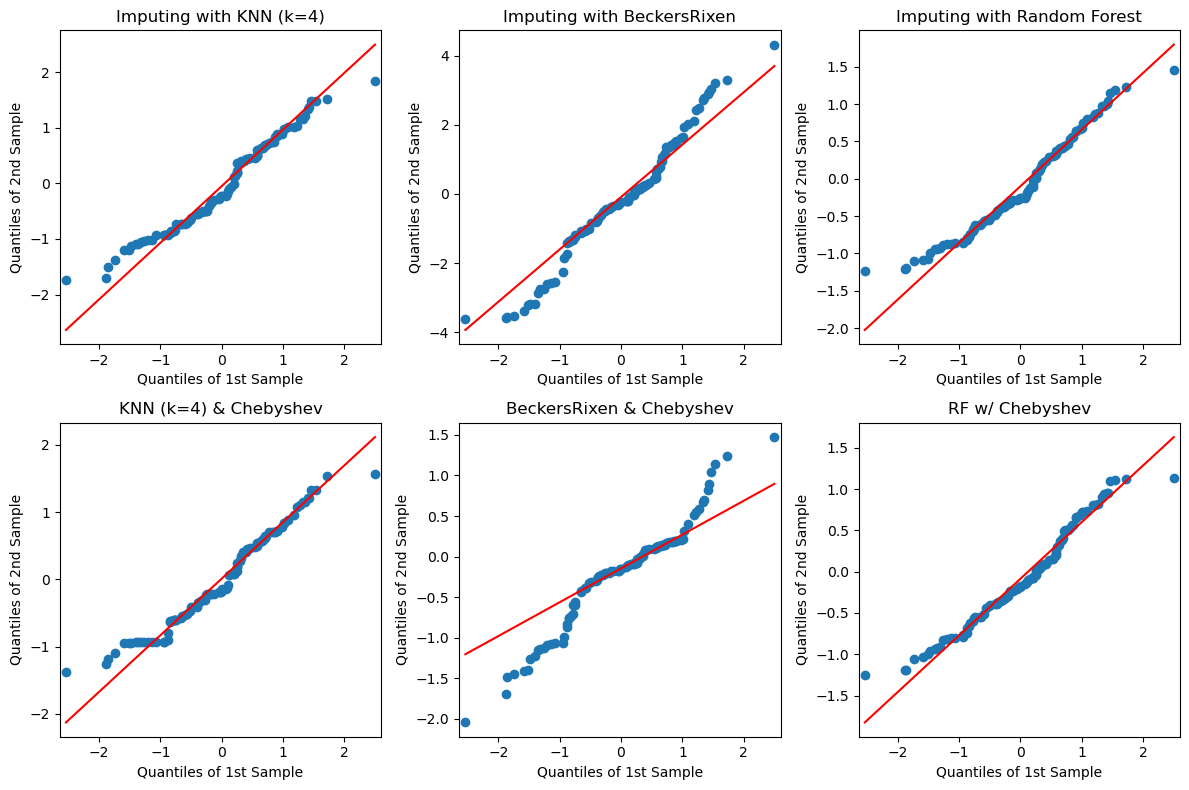

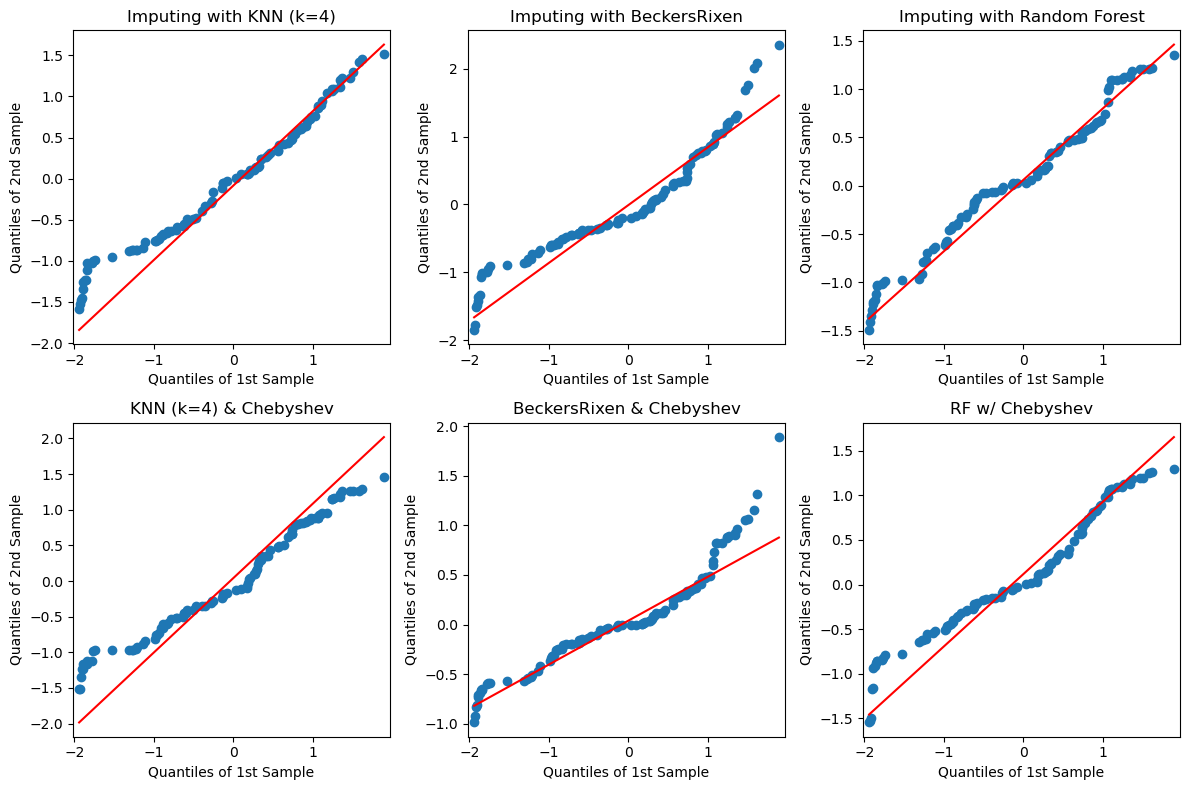

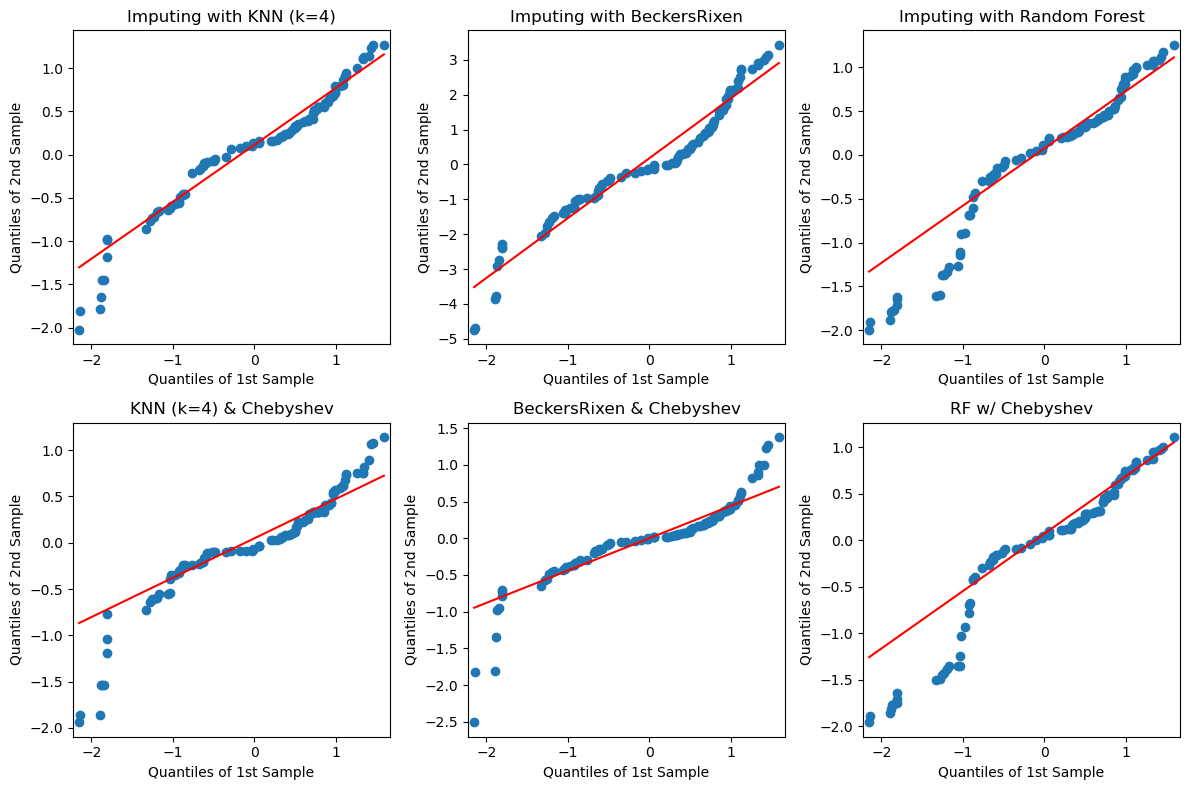

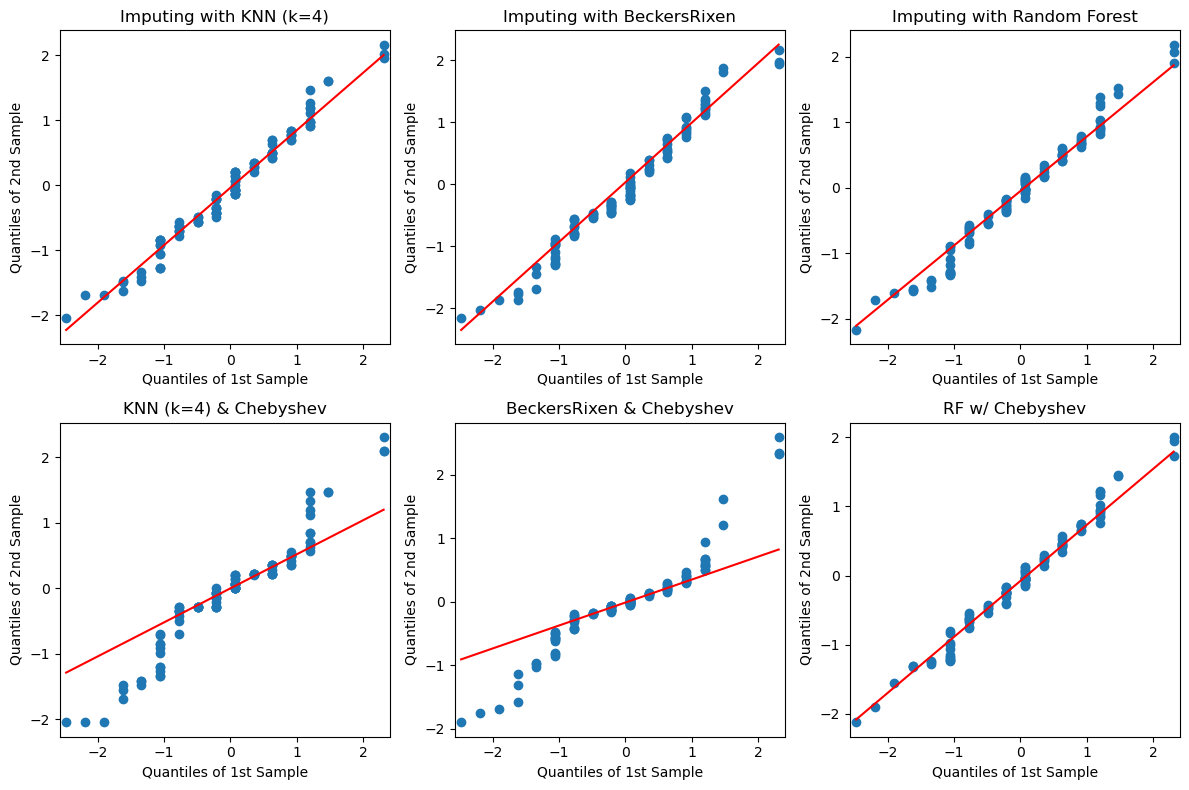

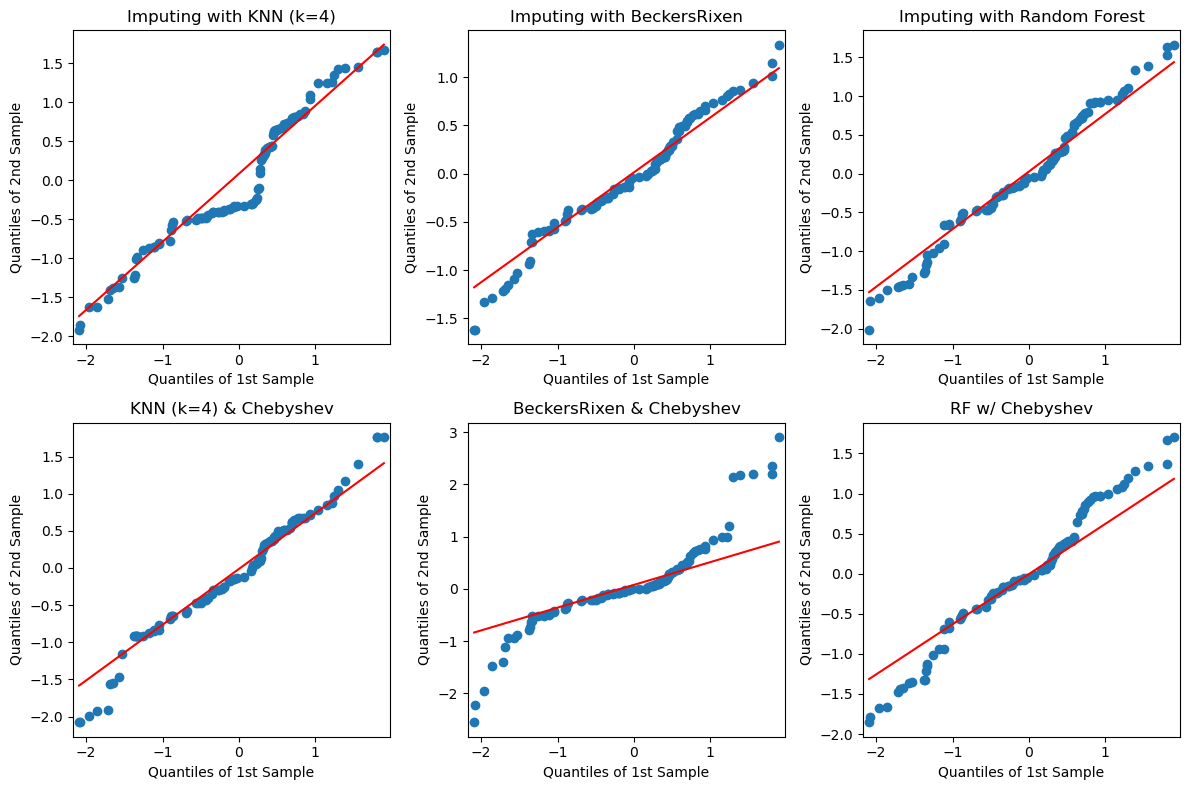

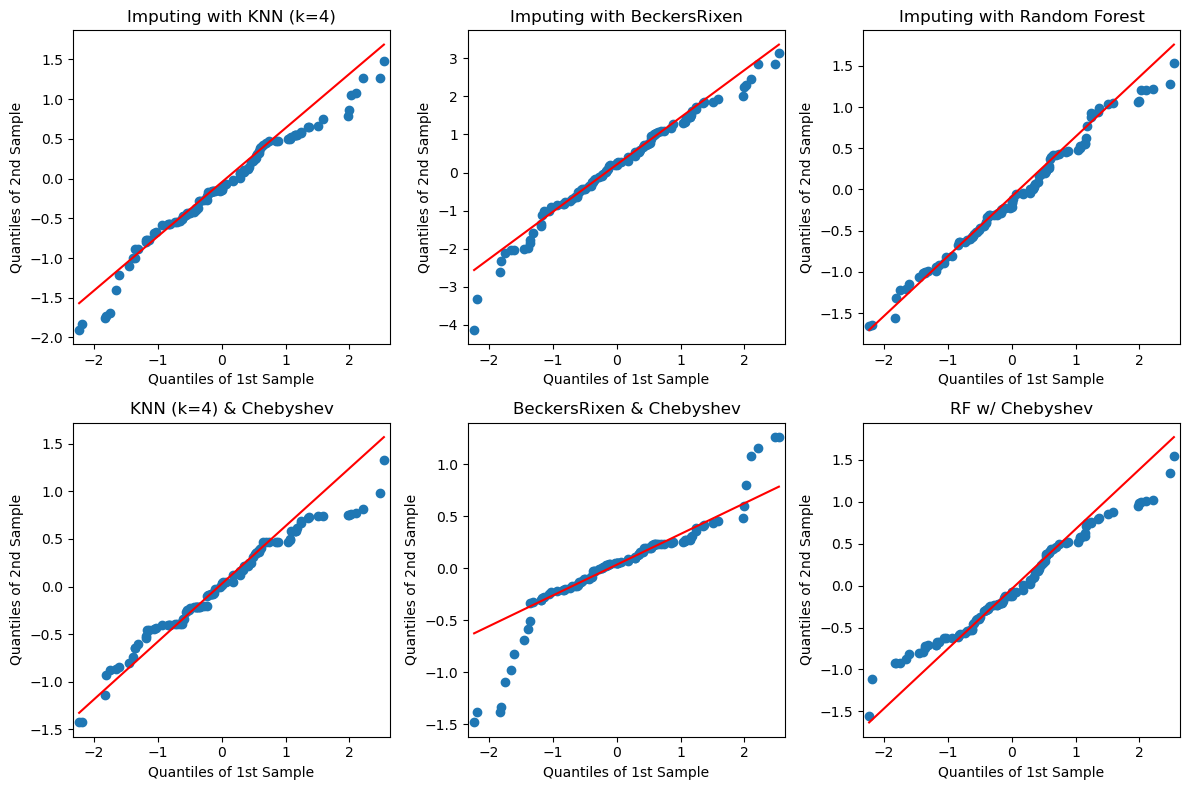

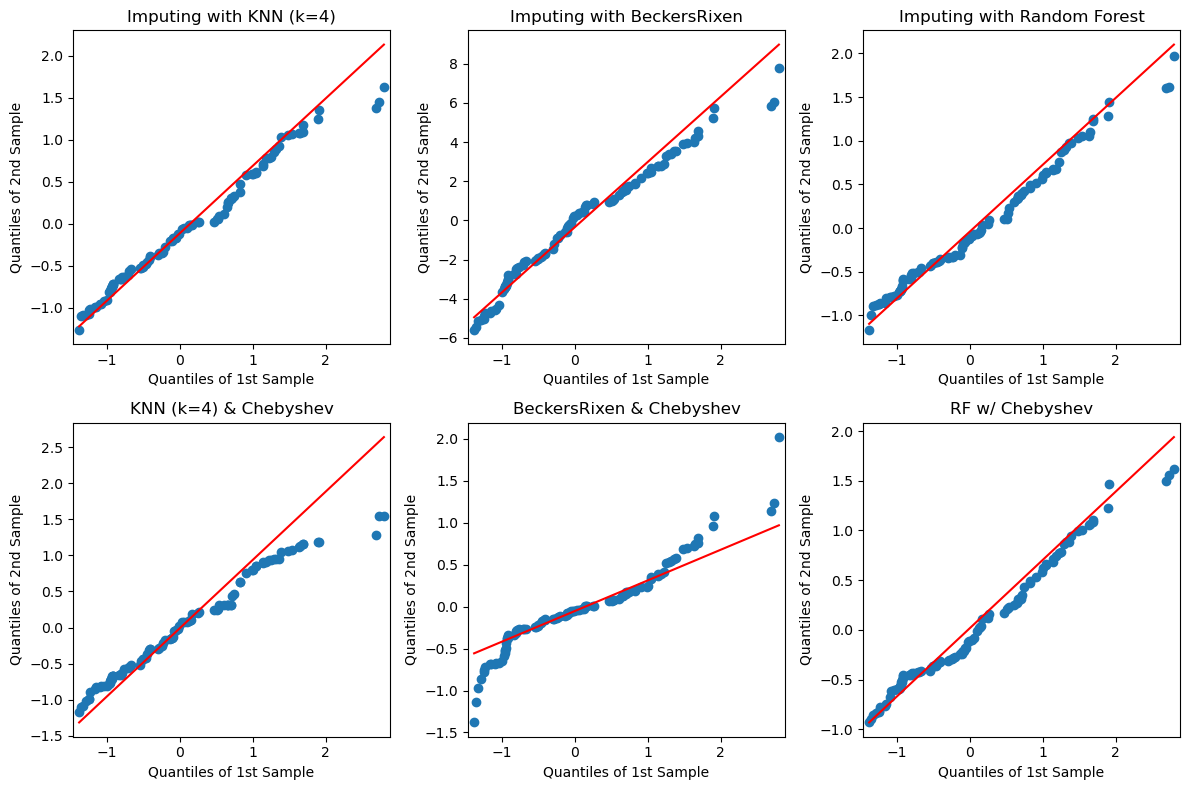

╒═══════════╤════════════╤════════════╤══════════╤══════════╤══════════╕
│           │       skew │   kurtosis │      RMS │       r2 │      MAE │
╞═══════════╪════════════╪════════════╪══════════╪══════════╪══════════╡
│ w/o Cheby │ -0.0477157 │  -0.292586 │ 0.886373 │ 0.669059 │ 0.69372  │
├───────────┼────────────┼────────────┼──────────┼──────────┼──────────┤
│ w/ Cheby  │ -0.0526087 │   0.64984  │ 0.757595 │ 0.627248 │ 0.602921 │
╘═══════════╧════════════╧════════════╧══════════╧══════════╧══════════╛
╒═════════╤══════════╤═════════════╤═════════════════╤════════════╤═════════════════╤════════════╕
│         │      KNN │   KNN Cheby │   Beckers Rixen │   BR-Cheby │   Random Forest │   RF Cheby │
╞═════════╪══════════╪═════════════╪═════════════════╪════════════╪═════════════════╪════════════╡
│ avg RMS │ 0.677178 │    0.824758 │        1.3561   │   0.813808 │        0.625844 │   0.634219 │
├─────────┼──────────┼─────────────┼─────────────────┼────────────┼─────────────────┼────────

In [6]:
data = pd.read_csv('./EOF_720_log10.csv')

subset = data.iloc[[0, 3, 4, 5, 6, 7, 8], :].to_numpy()
subset2 = subset[:, ~np.isnan(subset).any(axis=0)]
subset2_rand = subset2[:, np.random.permutation(subset2.shape[1])]

M0 = subset2_rand.copy()
M0[0, 174:] = np.nan

# Initialize training and testing sets for RF algorithm
M0trainX = M0[1:7, :174].T
M0trainY = M0[0, :174]
M0predX = M0[1:7, 174:].T

# Run each imputation algorithm on each variable in the subset matrix

# Initialize diagnostics tables, 6 methods of imputation
rmses = np.zeros((subset2_rand.shape[0], 6))
skews = np.zeros((subset2_rand.shape[0], 6))
kurts = np.zeros((subset2_rand.shape[0], 6))
r2 = np.zeros((subset2_rand.shape[0], 6))
maes = np.zeros((subset2_rand.shape[0], 6))
kl_divs = np.zeros((subset2_rand.shape[0], 6))
for i in range(7):
    trainsubset = np.delete(subset2_rand.copy(), i, axis=0)

    # Prepare M0 for input to KNN
    M0 = subset2_rand.copy()
    M0[i, 174:] = np.nan

    # Prepare M0 for KNN with Chebyshev Polynomials
    n = subset2_rand.shape[0] - 1 #6
    m = subset2_rand.shape[1]     #281
    M0Cheby = np.zeros((31, m))
    M0Cheby[:7, :] = subset2_rand.copy()
    M0Cheby[i, 174:] = np.nan

    M0Cheby[7:13, :] = chebyt(2)(trainsubset[:, :].flatten()).reshape((6, -1))
    M0Cheby[13:19, :] = chebyt(3)(trainsubset[:, :].flatten()).reshape((6, -1))
    M0Cheby[19:25, :] = chebyt(4)(trainsubset[:, :].flatten()).reshape((6, -1))
    M0Cheby[25:31, :] = chebyt(5)(trainsubset[:, :].flatten()).reshape((6, -1))

    # Prepare M0 for Beckers Rixen
    M02 = subset2_rand.copy()
    M02[i, 174:] = 0

    # Prepare M0 for Beckers Rixen with Chebyshev Polynomials
    M02Cheby = M0Cheby.copy()
    M02Cheby[i, 174:] = 0

    # Prepare M0 for RF
    M0trainX = trainsubset[:, :174]
    M0trainY = M0[i, :174]
    M0predX = trainsubset[:, 174:]

    # RF w/ Chebyshev Polynomials
    M0trainXCheby = np.zeros((30, 174))
    M0trainXCheby[:6, :] = trainsubset[:, :174]
    M0trainXCheby[6:12, :] = chebyt(2)(trainsubset[:, :174].flatten()).reshape((6, -1))
    M0trainXCheby[12:18, :] = chebyt(3)(trainsubset[:, :174].flatten()).reshape((6, -1))
    M0trainXCheby[18:24, :] = chebyt(4)(trainsubset[:, :174].flatten()).reshape((6, -1))
    M0trainXCheby[24:30, :] = chebyt(5)(trainsubset[:, :174].flatten()).reshape((6, -1))
    M0trainYCheby = M0[i,:174]
    M0predXCheby = np.zeros((30, trainsubset.shape[1] - 174))
    M0predXCheby[:6] = trainsubset[:, 174:]
    M0predXCheby[6:12, :] = chebyt(2)(trainsubset[:, 174:].flatten()).reshape((6, -1))
    M0predXCheby[12:18, :] = chebyt(3)(trainsubset[:, 174:].flatten()).reshape((6, -1))
    M0predXCheby[18:24, :] = chebyt(4)(trainsubset[:, 174:].flatten()).reshape((6, -1))
    M0predXCheby[24:30, :] = chebyt(5)(trainsubset[:, 174:].flatten()).reshape((6, -1))

    # Run imputation algorithms and calculate diagnostics

    # KNN
    k=4
    imputer = KNNImputer(n_neighbors=k)
    M0imputed_knn = imputer.fit_transform(M0.T).T
    M0imputed_knn_cheby = imputer.fit_transform(M0Cheby.T).T

    # Beckers-Rixen
    M0imputed_br, U1, S1, V1 = BeckersRixen(M02)
    M0imputed_br_cheby, U2, S2, V2 = BeckersRixen(M02Cheby)

    # Random Forest
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(M0trainX.T, M0trainY)
    M0imputed_rf = rf.predict(M0predX.T).T
    rf_cheby = RandomForestRegressor(n_estimators=100)
    rf_cheby.fit(M0trainXCheby.T, M0trainY)
    M0imputed_rf_cheby = rf_cheby.predict(M0predXCheby.T).T

    # Calculate diagnostics
    target_vals = subset2_rand[i, 174:]
    
    rmses[i, 0] = np.sqrt(np.mean((target_vals - M0imputed_knn[i, 174:]) ** 2))
    rmses[i, 1] = np.sqrt(np.mean((target_vals - M0imputed_knn_cheby[i, 174:]) ** 2))
    rmses[i, 2] = np.sqrt(np.mean((target_vals - M0imputed_br[i, 174:]) ** 2))
    rmses[i, 3] = np.sqrt(np.mean((target_vals - M0imputed_br_cheby[i, 174:]) ** 2))
    rmses[i, 4] = np.sqrt(np.mean((target_vals - M0imputed_rf) ** 2))
    rmses[i, 5] = np.sqrt(np.mean((target_vals - M0imputed_rf_cheby) ** 2))

    maes[i, 0] = np.mean(np.abs(target_vals - M0imputed_knn[i, 174:]))
    maes[i, 1] = np.mean(np.abs(target_vals - M0imputed_knn_cheby[i, 174:]))
    maes[i, 2] = np.mean(np.abs(target_vals - M0imputed_br[i, 174:]))
    maes[i, 3] = np.mean(np.abs(target_vals - M0imputed_br_cheby[i, 174:]))
    maes[i, 4] = np.mean(np.abs(target_vals - M0imputed_rf))
    maes[i, 5] = np.mean(np.abs(target_vals - M0imputed_rf_cheby))

    pd_knn = pd.Series(M0imputed_knn[i, 174:])
    pd_knn_cheby = pd.Series(M0imputed_knn_cheby[i, 174:])
    pd_br = pd.Series(M0imputed_br[i, 174:])
    pd_br_cheby = pd.Series(M0imputed_br_cheby[i, 174:])
    pd_rf = pd.Series(M0imputed_rf)
    pd_rf_cheby = pd.Series(M0imputed_rf_cheby)

    pd_target = pd.Series(target_vals)

    r2[i, 0] = pd_knn.corr(pd_target)
    r2[i, 1] = pd_knn_cheby.corr(pd_target)
    r2[i, 2] = pd_br.corr(pd_target)
    r2[i, 3] = pd_br_cheby.corr(pd_target)
    r2[i, 4] = pd_rf.corr(pd_target)
    r2[i, 5] = pd_rf_cheby.corr(pd_target)

    skews[i, 0] = pd_knn.skew()
    skews[i, 1] = pd_knn_cheby.skew()
    skews[i, 2] = pd_br.skew()
    skews[i, 3] = pd_br_cheby.skew()
    skews[i, 4] = pd_rf.skew()
    skews[i, 5] = pd_rf_cheby.skew()

    kurts[i, 0] = pd_knn.kurtosis()
    kurts[i, 1] = pd_knn_cheby.kurtosis()
    kurts[i, 2] = pd_br.kurtosis()
    kurts[i, 3] = pd_br_cheby.kurtosis()
    kurts[i, 4] = pd_rf.kurtosis()
    kurts[i, 5] = pd_rf_cheby.kurtosis()

    # QQ Plots for each method
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    qqplot(target_vals, M0imputed_knn[i, 174:], ax=axs[0, 0], line="q")
    axs[0, 0].set_title('Imputing with KNN (k=4)')

    qqplot(target_vals, M0imputed_br[i, 174:], ax=axs[0, 1], line="q")
    axs[0, 1].set_title('Imputing with BeckersRixen')

    qqplot(target_vals, M0imputed_rf, ax=axs[0, 2], line="q")
    axs[0, 2].set_title('Imputing with Random Forest')

    qqplot(target_vals, M0imputed_knn_cheby[i, 174:], ax=axs[1, 0], line="q")
    axs[1, 0].set_title('KNN (k=4) & Chebyshev')

    qqplot(target_vals, M0imputed_br_cheby[i, 174:], ax=axs[1, 1], line="q")
    axs[1, 1].set_title('BeckersRixen & Chebyshev')

    qqplot(target_vals, M0imputed_rf_cheby, ax=axs[1, 2], line="q")
    axs[1, 2].set_title('RF w/ Chebyshev')

    plt.tight_layout()
    plt.show()

wo_br_idx = np.array([0,2,4])
w_br_idx = np.array([1,3,5])
# Performance metrics with Cheby
stats_without_cheby = [
    np.mean(skews[:,wo_br_idx]), np.mean(kurts[:,wo_br_idx]), np.mean(rmses[:,wo_br_idx]), np.mean(r2[:,wo_br_idx]), np.mean(maes[:,wo_br_idx])]
# Performance metrics without Cheby
stats_with_cheby = [
    np.mean(skews[:,w_br_idx]), np.mean(kurts[:,w_br_idx]), np.mean(rmses[:,w_br_idx]), np.mean(r2[:,w_br_idx]), np.mean(maes[:,w_br_idx])]

cheby_headers = ['', 'skew', 'kurtosis', 'RMS', 'r2', 'MAE']

print(tabulate([['w/o Cheby'] + stats_without_cheby, ['w/ Cheby'] + stats_with_cheby], headers = cheby_headers, tablefmt='fancy_grid'))

# Performance metrics per method
avg_rms = np.mean(rmses, axis=0)
avg_r2 = np.mean(r2, axis=0)
avg_mae = np.mean(maes, axis=0)

methods_headers = ['', 'KNN', 'KNN Cheby', 'Beckers Rixen', 'BR-Cheby', 'Random Forest', 'RF Cheby']

print(
    tabulate(
        [['avg RMS'] + avg_rms.tolist(), ['avg r2'] + avg_r2.tolist(), ['avg MAE'] + avg_mae.tolist()],
        headers = methods_headers,
        tablefmt='fancy_grid'))